### Laboratorium 3: Metody Bayesowskie

Importy

In [99]:
import numpy as np
from scipy import stats
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import datasets
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.stats import norm, multivariate_normal
from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer    
from sklearn.impute import SimpleImputer 
from sklearn.datasets import load_breast_cancer, load_iris, fetch_20newsgroups, fetch_openml
from sklearn.decomposition import PCA, KernelPCA
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer,FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SequentialFeatureSelector

1. Zaimplementuj Naiwny Klasyfikator Bayesa dla dancyh ciągłych zakładając normalny rozkład prawdopodobieństwa dla każdej z cech z osobna. W implementacji możesz użyć standardowego interfejsu scikit-learn dla modeli predykcyjnych - metody fit() oraz predict().

 2. Wyznacz $\mu_{i, C_{k}}$ , $\sigma^{2}_{i, C_{k}}$ - średnią i odchylenie standardowe ciągłej cechy $x_{i}$ dla danej klasy $C_{k}$, a następnie oblicz prawdopodobieństwo posterior korzystając z Twierdzenia Bayesa oraz wiarygodności danej wzorem Eq. 6.

In [100]:
class NaiveBayesClassifier:
    def __init__(self):
        self.unique_classes = None
        self.class_priors = None
        self.feature_means = None
        self.feature_stds = None

    def fit(self, features, labels):
        features = np.array(features)
        labels = np.array(labels)

        self.unique_classes = np.unique(labels)
        n_classes = len(self.unique_classes)
        n_features = features.shape[1]

        self.class_priors = np.zeros(n_classes)
        self.feature_means = np.zeros((n_classes, n_features))
        self.feature_stds = np.zeros((n_classes, n_features))

        for idx, class_label in enumerate(self.unique_classes):
            class_samples = features[labels == class_label]
            self.class_priors[idx] = class_samples.shape[0] / features.shape[0]
            self.feature_means[idx, :] = np.mean(class_samples, axis=0)
            self.feature_stds[idx, :] = np.std(class_samples, axis=0, ddof=1)

        return self

    def _calculate_gaussian_prob(self, feature_value, mean_value, std_value):
        variance = std_value ** 2
        exponent = np.exp(-((feature_value - mean_value) ** 2 / (2 * variance)))
        return (1 / (np.sqrt(2 * np.pi * variance))) * exponent

    def predict(self, test_features):
        test_features = np.array(test_features)
        n_samples = test_features.shape[0]
        log_probabilities = np.zeros((n_samples, len(self.unique_classes)))

        for idx, class_label in enumerate(self.unique_classes):
            log_prior = np.log(self.class_priors[idx])

            log_likelihood = np.zeros(n_samples)
            for feature_idx in range(test_features.shape[1]):
                feature_probs = self._calculate_gaussian_prob(test_features[:, feature_idx], 
                                                              self.feature_means[idx, feature_idx], 
                                                              self.feature_stds[idx, feature_idx])
                log_likelihood += np.log(feature_probs + 1e-10)

            log_probabilities[:, idx] = log_prior + log_likelihood

        return self.unique_classes[np.argmax(log_probabilities, axis=1)]

 3. Przetestu działanie własnej implementacji klasyfikatora dla zbioru danych $Iris$ (4 cechy). Zastosuj losowy podział zbioru danych na część treningową i testową według proporcji 0.6, 0.4. Powtórz eksperyment 20-krotnie i zmierz średnie wartości:
 * $accuracy$
 * $f1-score$
 * $precision$
 Porównaj wyniki uzyskane z zastosowania własnej implementacji oraz wyniki uzyskane za pomocą scikit-learn GaussianNB

In [101]:
iris = load_iris()
X, y = iris.data, iris.target

In [102]:
def test_naive_bayes_classifiers(X, y, n_experiments=20, test_size=0.4):
    my_classifier_accuracy = []
    my_classifier_f1 = []
    my_classifier_precision = []
    
    sklearn_classifier_accuracy = []
    sklearn_classifier_f1 = []
    sklearn_classifier_precision = []
    
    for _ in range(n_experiments):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=None)
        
        my_nb = NaiveBayesClassifier()
        my_nb.fit(X_train, y_train)
        y_pred_my = my_nb.predict(X_test)
        
        sklearn_nb = GaussianNB()
        sklearn_nb.fit(X_train, y_train)
        y_pred_sklearn = sklearn_nb.predict(X_test)
        
        my_classifier_accuracy.append(accuracy_score(y_test, y_pred_my))
        my_classifier_f1.append(f1_score(y_test, y_pred_my, average='macro'))
        my_classifier_precision.append(precision_score(y_test, y_pred_my, average='macro'))
        
        sklearn_classifier_accuracy.append(accuracy_score(y_test, y_pred_sklearn))
        sklearn_classifier_f1.append(f1_score(y_test, y_pred_sklearn, average='macro'))
        sklearn_classifier_precision.append(precision_score(y_test, y_pred_sklearn, average='macro'))
    
    return {
        "My Naive Bayes": {
            "accuracy": np.mean(my_classifier_accuracy),
            "f1-score": np.mean(my_classifier_f1),
            "precision": np.mean(my_classifier_precision)
        },
        "Scikit-learn GaussianNB": {
            "accuracy": np.mean(sklearn_classifier_accuracy),
            "f1-score": np.mean(sklearn_classifier_f1),
            "precision": np.mean(sklearn_classifier_precision)
        }
    }


In [103]:
results = test_naive_bayes_classifiers(X, y, n_experiments=20, test_size=0.4)

print("Średnie wyniki dla własnej implementacji:")
print(f"Accuracy: {results['My Naive Bayes']['accuracy']}")
print(f"F1-score: {results['My Naive Bayes']['f1-score']}")
print(f"Precision: {results['My Naive Bayes']['precision']}")

print("\nŚrednie wyniki dla GaussianNB z scikit-learn:")
print(f"Accuracy: {results['Scikit-learn GaussianNB']['accuracy']}")
print(f"F1-score: {results['Scikit-learn GaussianNB']['f1-score']}")
print(f"Precision: {results['Scikit-learn GaussianNB']['precision']}")


Średnie wyniki dla własnej implementacji:
Accuracy: 0.95
F1-score: 0.9482645937483968
Precision: 0.9497445821668183

Średnie wyniki dla GaussianNB z scikit-learn:
Accuracy: 0.9491666666666667
F1-score: 0.9474923801751972
Precision: 0.9490896114065844


Wyniki dla obu implementacji – własnej oraz klasy GaussianNB z biblioteki scikit-learn – są bardzo zbliżone, co świadczy o poprawności działania własnej implementacji. Średnia dokładność (accuracy) w obu przypadkach wynosi około 95%, a wartości F1-score i precision również różnią się nieznacznie. Te minimalne różnice wskazują, że zarówno własna implementacja, jak i implementacja scikit-learn, dobrze radzą sobie z klasyfikacją, co potwierdza wysoką zgodność między nimi.

 4. Przetestuj działanie klasyfikatora dla zbioru danych $Breast$$Cancer$ (30 cech). Zastosuj trzy podane wyżej miary jakości klasyfikacji. Jako zbiór testowy wykorzystaj 0.3 dostępnego zbioru danych. Zbadaj wpływ:
* skalowania (StandardScaler)
* redukcji wymiaru (PCA i Kernel PCA, dobierz najlepszą wartość n.components oraz funkcję jądra na Kernel PCA)
* transformacji Box-Cox (dobierz najlepszą wartość parametru $\lambda$)
na średnie wyniki klasyfikacji. Czy tego typu wstępne przetwarzanie zbioru danych wpływa na ich poprawę? Porównaj uzyskaną dokładność klasyfikacji (Naiwny Klasyfikator Bayesa) z dokładnością klasyfikacji uzyskaną dla lasów losowych (domyślnie wartości hiperparametrów) w tej samej konfiguracji eksperymentu. Omów uzyskane wyniki.

In [104]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [105]:
# BASIC
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

accuracy_basic = accuracy_score(y_test, y_pred)
precision_basic = precision_score(y_test, y_pred, average='weighted', zero_division=1)
f1_basic = f1_score(y_test, y_pred, average='weighted')

In [106]:
# SCALER
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gnb.fit(X_train_scaled, y_train)
y_pred_scaled = gnb.predict(X_test_scaled)

accuracy_scaled = accuracy_score(y_test, y_pred_scaled)
precision_scaled = precision_score(y_test, y_pred_scaled, average='weighted', zero_division=1)
f1_scaled = f1_score(y_test, y_pred_scaled, average='weighted')

In [107]:
# PCA
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

gnb.fit(X_train_pca, y_train)
y_pred_pca = gnb.predict(X_test_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
precision_pca = precision_score(y_test, y_pred_pca, average='weighted', zero_division=1)
f1_pca = f1_score(y_test, y_pred_pca, average='weighted')

In [108]:
# Kernel PCA
kernel_pca = KernelPCA(n_components=4, kernel='rbf')
X_train_kpca = kernel_pca.fit_transform(X_train)
X_test_kpca = kernel_pca.transform(X_test)

gnb.fit(X_train_kpca, y_train)
y_pred_kpca = gnb.predict(X_test_kpca)

accuracy_kpca = accuracy_score(y_test, y_pred_kpca)
precision_kpca = precision_score(y_test, y_pred_kpca, average='weighted', zero_division=1)
f1_kpca = f1_score(y_test, y_pred_kpca, average='weighted')

In [109]:
# Box-Cox 
pt = PowerTransformer(method='box-cox')
X_train_bc = X_train + 1e-6  # Dodanie małej stałej, aby wartości były dodatnie
X_test_bc = X_test + 1e-6

X_train_bc = pt.fit_transform(X_train_bc)
X_test_bc = pt.transform(X_test_bc)

gnb.fit(X_train_bc, y_train)
y_pred_bc = gnb.predict(X_test_bc)

accuracy_bc = accuracy_score(y_test, y_pred_bc)
precision_bc = precision_score(y_test, y_pred_bc, average='weighted', zero_division=1)
f1_bc = f1_score(y_test, y_pred_bc, average='weighted')

In [110]:
print("\nResults basic (Naive Bayes):")
print(f"Accuracy: {accuracy_basic}")
print(f"Precision: {precision_basic}")
print(f"F1-score: {f1_basic}")

print("\nResults after scaling (Naive Bayes):")
print(f"Accuracy: {accuracy_scaled}")
print(f"Precision: {precision_scaled}")
print(f"F1-score: {f1_scaled}")

print("\nResults after PCA (Naive Bayes):")
print(f"Accuracy: {accuracy_pca}")
print(f"Precision: {precision_pca}")
print(f"F1-score: {f1_pca}")

print("\nResults after Kernel PCA (Naive Bayes):")
print(f"Accuracy: {accuracy_kpca}")
print(f"Precision: {precision_kpca}")
print(f"F1-score: {f1_kpca}")

print("\nResults after Box-Cox transformation (Naive Bayes):")
print(f"Accuracy: {accuracy_bc}")
print(f"Precision: {precision_bc}")
print(f"F1-score: {f1_bc}")


Results basic (Naive Bayes):
Accuracy: 0.9415204678362573
Precision: 0.941391481684838
F1-score: 0.9413171134406007

Results after scaling (Naive Bayes):
Accuracy: 0.935672514619883
Precision: 0.9355228111711654
F1-score: 0.9355634246907591

Results after PCA (Naive Bayes):
Accuracy: 0.9298245614035088
Precision: 0.9321564098333608
F1-score: 0.9286988658085892

Results after Kernel PCA (Naive Bayes):
Accuracy: 0.631578947368421
Precision: 0.7673130193905817
F1-score: 0.48896434634974534

Results after Box-Cox transformation (Naive Bayes):
Accuracy: 0.9532163742690059
Precision: 0.9532163742690059
F1-score: 0.9532163742690059


Podstawowy Naive Bayes działa bardzo dobrze, natomiast transformacja Box-Cox poprawia wyniki klasyfikacji. Skalowanie i PCA mają niewielki lub negatywny wpływ, a Kernel PCA znacznie pogarsza wyniki, co może wskazywać na nieoptymalne dostosowanie tego przetwarzania do modelu Naive Bayes.

In [111]:
# Random Forest (BASIC)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=1)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

In [112]:
# SCALER dla Random Forest
rf_classifier.fit(X_train_scaled, y_train)
y_pred_rf_scaled = rf_classifier.predict(X_test_scaled)

accuracy_rf_scaled = accuracy_score(y_test, y_pred_rf_scaled)
precision_rf_scaled = precision_score(y_test, y_pred_rf_scaled, average='weighted', zero_division=1)
f1_rf_scaled = f1_score(y_test, y_pred_rf_scaled, average='weighted')

In [113]:
# PCA dla Random Forest
rf_classifier.fit(X_train_pca, y_train)
y_pred_rf_pca = rf_classifier.predict(X_test_pca)

accuracy_rf_pca = accuracy_score(y_test, y_pred_rf_pca)
precision_rf_pca = precision_score(y_test, y_pred_rf_pca, average='weighted', zero_division=1)
f1_rf_pca = f1_score(y_test, y_pred_rf_pca, average='weighted')

In [114]:
# Kernel PCA dla Random Forest
rf_classifier.fit(X_train_kpca, y_train)
y_pred_rf_kpca = rf_classifier.predict(X_test_kpca)

accuracy_rf_kpca = accuracy_score(y_test, y_pred_rf_kpca)
precision_rf_kpca = precision_score(y_test, y_pred_rf_kpca, average='weighted', zero_division=1)
f1_rf_kpca = f1_score(y_test, y_pred_rf_kpca, average='weighted')

In [115]:
# Box-Cox dla Random Forest
rf_classifier.fit(X_train_bc, y_train)
y_pred_rf_bc = rf_classifier.predict(X_test_bc)

accuracy_rf_bc = accuracy_score(y_test, y_pred_rf_bc)
precision_rf_bc = precision_score(y_test, y_pred_rf_bc, average='weighted', zero_division=1)
f1_rf_bc = f1_score(y_test, y_pred_rf_bc, average='weighted')

In [116]:
print("\nResults basic (Random Forest):")
print(f"Accuracy (Original): {accuracy_rf}")
print(f"Precision (Original): {precision_rf}")
print(f"F1-score (Original): {f1_rf}")

print("\nResults after scaling (Random Forest):")
print(f"Accuracy: {accuracy_rf_scaled}")
print(f"Precision: {precision_rf_scaled}")
print(f"F1-score: {f1_rf_scaled}")

print("\nResults after PCA (Random Forest):")
print(f"Accuracy: {accuracy_rf_pca}")
print(f"Precision: {precision_rf_pca}")
print(f"F1-score: {f1_rf_pca}")

print("\nResults after Kernel PCA (Random Forest):")
print(f"Accuracy: {accuracy_rf_kpca}")
print(f"Precision: {precision_rf_kpca}")
print(f"F1-score: {f1_rf_kpca}")

print("\nResults after Box-Cox transformation (Random Forest):")
print(f"Accuracy: {accuracy_rf_bc}")
print(f"Precision: {precision_rf_bc}")
print(f"F1-score: {f1_rf_bc}")


Results basic (Random Forest):
Accuracy (Original): 0.9707602339181286
Precision (Original): 0.9711000474158369
F1-score (Original): 0.970603923775359

Results after scaling (Random Forest):
Accuracy: 0.9707602339181286
Precision: 0.9711000474158369
F1-score: 0.970603923775359

Results after PCA (Random Forest):
Accuracy: 0.9649122807017544
Precision: 0.9649541140481607
F1-score: 0.9647902680643604

Results after Kernel PCA (Random Forest):
Accuracy: 0.631578947368421
Precision: 0.7673130193905817
F1-score: 0.48896434634974534

Results after Box-Cox transformation (Random Forest):
Accuracy: 0.9707602339181286
Precision: 0.9711000474158369
F1-score: 0.970603923775359


W tym przypadku również możemy zaobserwować podobną zależność co wcześniej tylko, że zamiast Podstawowego Naive Bayes mamy Random Forest, który działa bardzo dobrze bez potrzeby dodatkowego przetwarzania danych. Skalowanie i transformacja Box-Cox nie przynoszą zmian w wynikach, PCA lekko obniża wyniki, a Kernel PCA zdecydowanie pogarsza jakość klasyfikacji.

5. Zaimplementuj Naiwny Klasyfikator Bayesa zakładając rozkład prawdopodobieństwa Bernoulliego dla każdej z binarnych cech. Wykorzystaj wygładzenie Laplace'a ($Laplace$$smoothing$) w celu uniknięcia problemów związanych z zerowaniem się prawdopodobieństwa przy wystąpieniu danych, które nie pojawiły się w danej klasie w zbiorze treningowym. Przedstaw test działania klasyfikatora korzystając z wybranego zbioru danych złożonego z krótkich tekstów (np. $20$$news$$groups$). 

In [117]:
newsgroups = fetch_20newsgroups(subset='train', categories=['sci.space', 'comp.graphics'])
X_text, y = newsgroups.data, newsgroups.target

In [118]:
# Przekształcenie tekstu na macierz cech binarnych 
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(X_text)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [119]:
class BernoulliNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # Wygładzenie Laplace'a
        self.class_log_prior_ = None
        self.feature_log_prob_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        
        # Inicjalizacja macierzy na priorytety klas i prawdopodobieństwa cech
        class_count = np.zeros(n_classes, dtype=np.float64)
        feature_count = np.zeros((n_classes, n_features), dtype=np.float64)
        
        # Priorytety klas i liczność cech dla każdej klasy
        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            class_count[idx] = X_c.shape[0]
            feature_count[idx, :] = np.sum(X_c, axis=0)
        
        # Priorytety klas log(P(C_k))
        self.class_log_prior_ = np.log(class_count + self.alpha) - np.log(n_samples + n_classes * self.alpha)
        
        # Logarytmy prawdopodobieństw cech log(P(x_i|C_k))
        smoothed_fc = feature_count + self.alpha
        smoothed_cc = class_count[:, np.newaxis] + 2 * self.alpha
        self.feature_log_prob_ = np.log(smoothed_fc) - np.log(smoothed_cc)

    def predict_log_proba(self, X):
        return (X @ self.feature_log_prob_.T) + self.class_log_prior_

    def predict(self, X):
        log_probs = self.predict_log_proba(X)
        return self.classes_[np.argmax(log_probs, axis=1)]

In [120]:
# Ręczna implementacja Bernoulli Naive Bayes
my_bnb = BernoulliNaiveBayes(alpha=1.0)
my_bnb.fit(X_train, y_train)
y_pred_my = my_bnb.predict(X_test)

accuracy_my = accuracy_score(y_test, y_pred_my)
precision_my = precision_score(y_test, y_pred_my, average='weighted')
f1_my = f1_score(y_test, y_pred_my, average='weighted')

In [121]:
print(f"Accuracy (manual):{accuracy_my}")
print(f"Precision (manual): {precision_my}")
print(f"F1-score (manual): {f1_my}")

Accuracy (manual):0.8785310734463276
Precision (manual): 0.9023811366509299
F1-score (manual): 0.8767989610387236


In [122]:
# Implementacja z sklearn
bnb = BernoulliNB(alpha=1.0)
bnb.fit(X_train, y_train)
y_pred_sklearn = bnb.predict(X_test)

accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
precision_sklearn = precision_score(y_test, y_pred_sklearn, average='weighted')
f1_sklearn = f1_score(y_test, y_pred_sklearn, average='weighted')

In [123]:
print(f"Accuracy (sklearn): {accuracy_sklearn}")
print(f"Precision (sklearn): {precision_sklearn}")
print(f"F1-score (sklearn): {f1_sklearn}")

Accuracy (sklearn): 0.8615819209039548
Precision (sklearn): 0.8841251452890221
F1-score (sklearn): 0.859409507807696


Ręczna implementacja Bernoulli Naive Bayes z wygładzeniem Laplace’a poradziła sobie lepiej pod względem wszystkich trzech metryk (accuracy, precision, F1-score) niż gotowa implementacja z biblioteki scikit-learn. Różnice nie są duże, ale wskazują, że własna wersja modelu mogła lepiej dopasować się do danych.

6. Wykorzystując $hold-out$ w proporcji $70\% $, $30\% $ zbadaj bazową dokładność klasyfikatora NKB dla zbioru Adult Income. Wypisz średnią dokładność klasyfikacji oraz odchylenie standardowe dla 50 podziałów (baseline). Następnie zaproponuj kilka strategii wstępnego przetwarzania zbioru danych (obsługa brakujących wartości, NA, ...), kilka strategii inżynierii cech (kodowanie cehc nominalnych, skalowanie, wielokrotne transformacje Box-Cox, ...) oraz selekcji cech (Sequential Feature Selection), tak aby poprawić dokładność klasyfikacji (zbliżyć się do $84\%$). W implementacji możesz wykorzystać sklearn.pipeline. Pipeline oraz zarówno biblioteczne, jak i własne implementacje klasyfikatorów NKB.

In [124]:
data = fetch_openml(data_id=1590, as_frame=True)
X = data.data
y = data.target
y = y.apply(lambda x: 1 if x == '>50K' else 0)

In [125]:
# Wybór cech numerycznych i kategorycznych
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [126]:
# Funkcja przesunięcia wartości na dodatnie
def shift_positive(X):
    return X + (np.abs(np.min(X, axis=0)) + 1)

In [127]:
# Funkcja oceny bazowej dokładności
def evaluate_baseline(X, y, n_splits=50):
    accuracies = []
    for _ in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    mean_accuracy = np.mean(accuracies)
    std_dev_accuracy = np.std(accuracies)
    return mean_accuracy, std_dev_accuracy

In [128]:
# Preprocessing z imputerami i skalowaniem
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', KNNImputer()), 
            ('scaler', StandardScaler())
        ]), numeric_features),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Pipeline bazowy z klasyfikatorem BernoulliNB
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BernoulliNB())
])

# Preprocessing z transformacjami Box-Cox
preprocessor_with_boxcox = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('shift_positive', FunctionTransformer(shift_positive)),
            ('boxcox', PowerTransformer(method='box-cox')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Pipeline bez selekcji cech
pipeline_with_boxcox = Pipeline(steps=[
    ('preprocessor', preprocessor_with_boxcox),
    ('classifier', BernoulliNB())
])

In [129]:
# Funkcja oceny pipeline'u z selekcją cech
def evaluate_pipeline_with_selection(X, y, n_splits=50):
    accuracies = []
    for _ in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
        
        X_train_preprocessed = preprocessor_with_boxcox.fit_transform(X_train)
        X_test_preprocessed = preprocessor_with_boxcox.transform(X_test)
        
        selector = SequentialFeatureSelector(BernoulliNB(), n_features_to_select=0.9)
        selector.fit(X_train_preprocessed, y_train)
        
        X_train_selected = selector.transform(X_train_preprocessed)
        X_test_selected = selector.transform(X_test_preprocessed)
        
        classifier = BernoulliNB()
        classifier.fit(X_train_selected, y_train)
        
        y_pred = classifier.predict(X_test_selected)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    mean_accuracy = np.mean(accuracies)
    std_dev_accuracy = np.std(accuracies)
    return mean_accuracy, std_dev_accuracy

In [130]:
accuracy_baseline, std_dev_baseline = evaluate_baseline(X, y)
print(f"Baseline accuracy: {accuracy_baseline}")
print(f"Baseline standard deviation: {std_dev_baseline}")

accuracy_with_selection, std_dev_with_selection = evaluate_pipeline_with_selection(X, y)
print(f"Accuracy with feature selection and Box-Cox: {accuracy_with_selection}")
print(f"Standard deviation with feature selection: {std_dev_with_selection}")

Baseline accuracy: 0.8031488432402921
Baseline standard deviation: 0.002699490668563337
Accuracy with feature selection and Box-Cox: 0.8038504060601926
Standard deviation with feature selection: 0.004004434364674031


7. Zaimplementuj Liniową Regresję Bayesowską w wersji online korzystając z poniższej klasy pomocniczej

In [131]:
class BayesianLinearRegression:

    def __init__(self, n_features, alpha, beta):
        self.n_features = n_features
        self.alpha = alpha
        self.beta = beta
        self.mean = np.zeros(n_features)
        self.cov_inv = np.identity(n_features) / alpha

    def learn(self, x, y):
        cov_inv = self.cov_inv + self.beta * np.outer(x, x)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y * x)
        self.cov_inv = cov_inv
        self.mean = mean

        return self

    def predict(self, x):
        y_pred_mean = x @ self.mean
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + x @ w_cov @ x.T

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)

    @property
    def weights_dist(self):
        cov = np.linalg.inv(self.cov_inv)
        return stats.multivariate_normal(mean=self.mean, cov=cov)

8. Wygeneruj sztuczny zbiór danych w 2D (10 punktów z przedziału [-1, 1] zgodnie ze wzorem $t=-0.2+0.6x+\epsilon$, gdzie $\epsilon$ jest szumem Gaussowskim o średniej 0 i odchyleniu standardowym 0.2. 

In [132]:
# Wagi dla równania liniowego
weights = np.array([-.2, .6])

def sample(n):
    for _ in range(n):
        x = np.array([1, np.random.uniform(-1, 1)])
        y = np.dot(weights, x) + np.random.normal(0, .2)
        yield x, y


9. Zwizualizuj kolejne kroki Liniowej Regresji Bayesowskiej online ($β = 25, α = 2$) dla pierwszych 7 punktów ze zbioru danych. Dla każdego kroku $i$:
a) Narysuj (contourf()) dwuwymiarowy rozkład prior dla wag $w_{1}$ i $w_{2}$ modelu $y= w_{1} + w_{2}x$
b) Narysuj (contourf()) dwuwymiarowy rozkład posterior dla wag $w_{1}$ i $w_{2}$
c) Narysuj rozkład predykcyjny (predictive mean, predictive interval), prostą $t=−0.2 + 0.6x$ oraz punkty wykorzystane do budowy rozkładu predykcyjnego.
* Pokaż jak zmienia się kształt rozkładu posterior wraz z dodawaniem kolejnych punktów?

In [133]:
model = BayesianLinearRegression(n_features=2, alpha=2, beta=25)

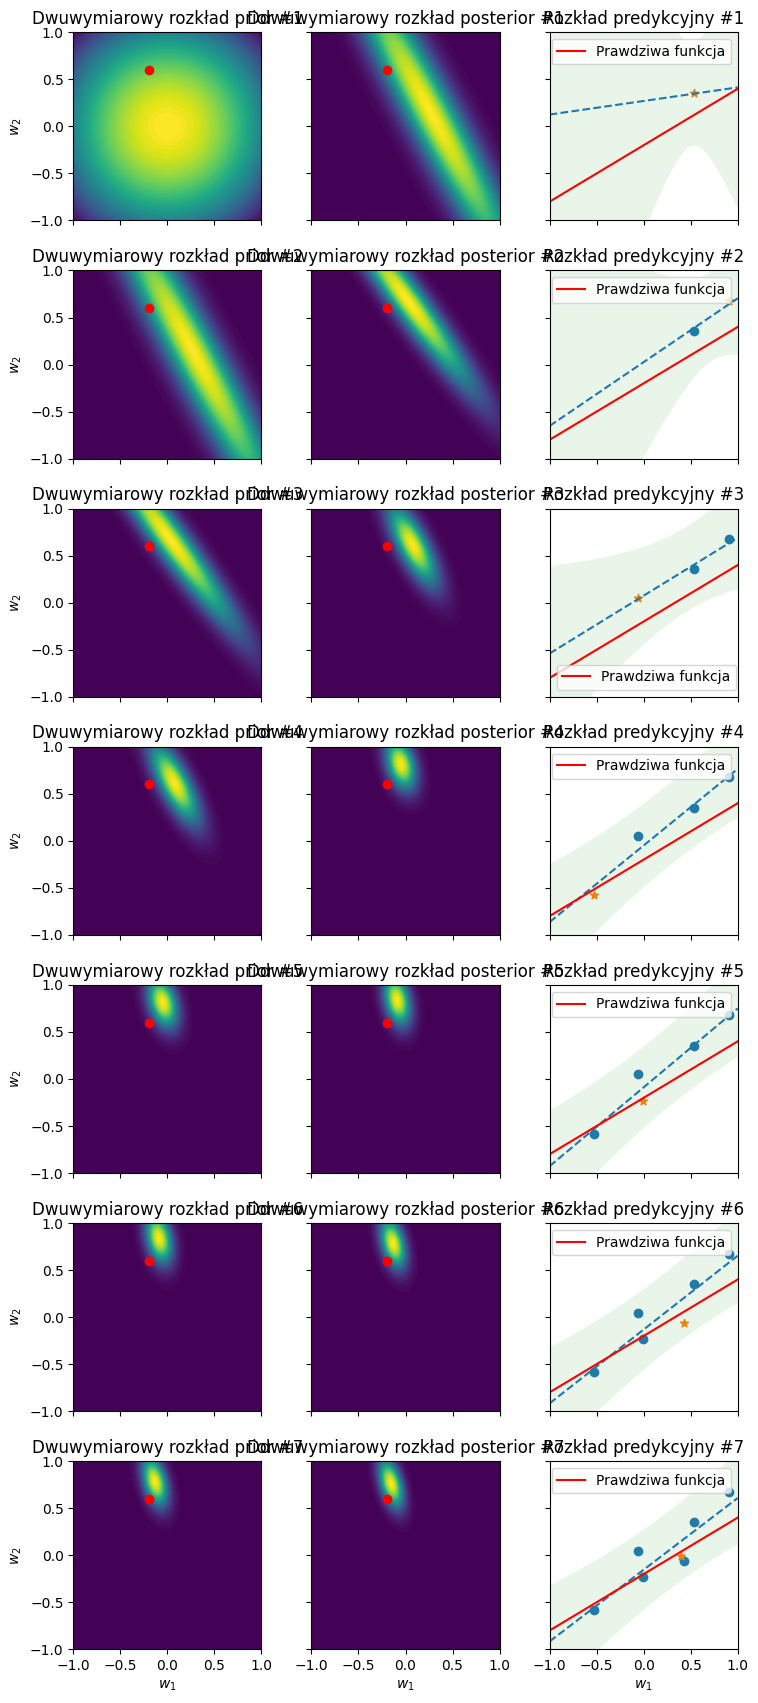

In [134]:
N = 100
w = np.linspace(-1, 1, N)
W = np.dstack(np.meshgrid(w, w))

n_samples = 7  
fig = plt.figure(figsize=(7 * n_samples, 21))
grid = ImageGrid(
    fig, 111,  
    nrows_ncols=(n_samples, 3),   
    axes_pad=.5  
)

# Przechowujemy wygenerowane punkty do wizualizacji
xs = []
ys = []

# Funkcja pomocnicza do formatowania osi
def prettify_ax(ax):
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('$w_1$')
    ax.set_ylabel('$w_2$')
    return ax

for i, (xi, yi) in enumerate(sample(n_samples)):

    pred_dist = model.predict(xi)


    # a) Dwuwymiarowy rozkład prior dla wag w1 i w2 modelu y = w1 + w2x 
    ax = prettify_ax(grid[3 * i])
    ax.set_title(f'Dwuwymiarowy rozkład prior #{i + 1}')
    ax.contourf(w, w, model.weights_dist.pdf(W), N, cmap='viridis')
    ax.scatter(*weights, color='red')
    model.learn(xi, yi)

    # b) Dwuwymiarowy rozkład posterior dla wag w1 i w2 
    ax = prettify_ax(grid[3 * i + 1])
    ax.set_title(f'Ddwuwymiarowy rozkład posterior #{i + 1}')
    ax.contourf(w, w, model.weights_dist.pdf(W), N, cmap='viridis')
    ax.scatter(*weights, color='red')

    xs.append(xi)
    ys.append(yi)
    posteriors = [model.predict(np.array([1, wi])) for wi in w]

    # c) Rozkład predykcyjny 
    ax = prettify_ax(grid[3 * i + 2])
    ax.set_title(f'Rozkład predykcyjny #{i + 1}')

    ax.scatter([xi[1] for xi in xs[:-1]], ys[:-1])
    ax.scatter(xs[-1][1], ys[-1], marker='*')
 
    ax.plot(w, [p.mean() for p in posteriors], linestyle='--')
    cis = [p.interval(.95) for p in posteriors]
    ax.fill_between(
        x=w,
        y1=[ci[0] for ci in cis],
        y2=[ci[1] for ci in cis],
        alpha=.1
    )
    
    ax.plot(w, [np.dot(weights, [1, xi]) for xi in w], color='red', label="Prawdziwa funkcja")
    ax.legend()

plt.show()